In [14]:
import warnings
import shap
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

In [8]:
%run TII_train_net_from_description.py

[82740, 131072, -7]
Epoch 1/100
14/14 [==============================] - 8s 77ms/step - loss: 0.6296 - val_loss: 0.5745 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.5375 - val_loss: 0.5047 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 0.4728 - val_loss: 0.4513 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 25ms/step - loss: 0.4213 - val_loss: 0.4023 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 24ms/step - loss: 0.3711 - val_loss: 0.3639 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 23ms/step - loss: 0.3329 - val_loss: 0.3325 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 0.3124 - val_loss: 0.3065 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 0s 24ms/step - loss: 0.2813 - val_loss: 0.2861 - lr: 0.0010
Epoch 9/100
14/14 [==============================] - 0s 23ms/step - loss: 0.

In [16]:
# We will now directly use the original 4D data
consistent_samples = []

In [17]:
# Loop through each index in fold_test_ind and select the first time step to match the expected shape
for idx in fold_test_ind[:100]:  # Limiting to the first 100 samples
    sample = Xd[idx]
    
    try:
        # Select the first time step (shape should be (64, 64, 8))
        sample_reshaped = np.array(sample[0])  # Taking the first time step
        
        # Append the reshaped sample to the list
        consistent_samples.append(sample_reshaped)
        
        print(f"Sample {idx} reshaped shape: {sample_reshaped.shape}")
        
    except Exception as e:
        print(f"Error at sample {idx}: {e}")


Sample [   8   12   15 ... 5643 5644 5646] reshaped shape: (64, 64, 8)
Sample [  14   19   24 ... 5648 5649 5650] reshaped shape: (64, 64, 8)
Sample [   0    6    7 ... 5642 5645 5647] reshaped shape: (64, 64, 8)
Sample [   1    2   10 ... 5632 5635 5637] reshaped shape: (64, 64, 8)
Sample [   3    4    5 ... 5638 5640 5641] reshaped shape: (64, 64, 8)


SHAP values shape: (5, 64, 64, 8, 2)
Data shape: (5, 64, 64, 8)
Aggregated SHAP values shape: (5, 8, 2)
Aggregated Data shape: (5, 8)


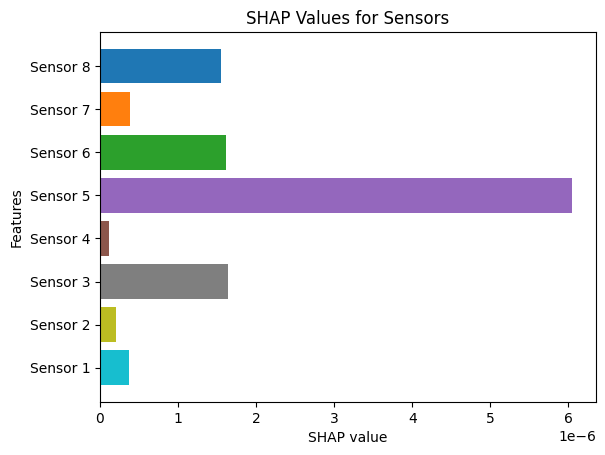

In [23]:
# Now use SHAP with the 4D consistent data
if len(consistent_samples) > 0:
    consistent_data = np.array(consistent_samples)  # Keep the data in 4D
    
    # Initialize SHAP explainer with the original 4D training data
    train_data_4d = np.array([Xd[idx][0] for idx in fold_train_ind[:100]])  # Taking the first time step
    explainer = shap.DeepExplainer(model, train_data_4d)  # Keep 4D data
    
    # Compute SHAP values on the 4D consistent test data
    shap_values = explainer.shap_values(consistent_data)

    # Inspect the shape of SHAP values and data
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Data shape: {consistent_data.shape}")

    # If SHAP values are a list, select the first output (for binary classification)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Aggregate SHAP values across the (64, 64) grid for each of the 8 sensors
    shap_values_per_sensor = np.mean(shap_values, axis=(1, 2))  # Mean across (64, 64) grid
    consistent_data_per_sensor = np.mean(consistent_data, axis=(1, 2))  # Mean across (64, 64) grid

    # Check the shapes after aggregation (should be (samples, 8 sensors))
    print(f"Aggregated SHAP values shape: {shap_values_per_sensor.shape}")
    print(f"Aggregated Data shape: {consistent_data_per_sensor.shape}")

    # Ensure we have 8 sensors in the output (if not, raise an error)
    if shap_values_per_sensor.shape[1] != 8:
        raise ValueError(f"Expected 8 sensors but got {shap_values_per_sensor.shape[1]}.")

    # Select the first output from SHAP values (for binary classification)
    shap_values_first_output = shap_values_per_sensor[:, :, 0]  # Select first output (shape: (samples, 8))

    # Plot sensors in order
    ordered_indices = np.argsort([8, 7, 6, 5, 4, 3, 2, 1])  
    shap_values_ordered = np.mean(np.abs(shap_values_first_output), axis=0)[ordered_indices]

    # Plot the SHAP values with distinct colors
    feature_names = [f'Sensor {i}' for i in range(8, 0, -1)]  # Reverse sensor names
    colormap = plt.get_cmap('tab10')  # Get the colormap
    colors = colormap(np.linspace(0, 1, len(feature_names)))  # Generate distinct colors for each bar

    plt.barh(feature_names, shap_values_ordered, color=colors)
    plt.ylabel("Features")
    plt.xlabel("SHAP value")
    plt.title("SHAP Values for Sensors")
    plt.gca().invert_yaxis()  # Invert y-axis so Sensor 8 is at the bottom
    plt.show()

else:
    print("No consistent samples found for SHAP analysis.")